# benchmark.
building a basic $E(3)$-equivariant message-passing graph neural network to predict internal energy at 0K on QM9 to make sure I am comfortable with this stuff in practice as well as in theory.

to-do:  
[] build a DataLoader to make MBGD easier.  
    [] build custom Graph class if necessary.  
[] learn how you're supposed to keep track of loss through training.  
[] separate training, test sets.  
[] figure out how to load in all of QM9 without crashing kernel.
[] build a version of the model only message-passing between nodes within a certain distance of each other.  
[] build a version of the model with edge attribute of the square of the distance between nodes, which makes more sense physically.  
[] figure out how to save trained model.
[] in general get better at memory management and whatnot and learn how this thing works at runtime to reduce the frequency at which my computer crashes (once per 15 minutes approximately at the moment: lots of room for improvement).

### import everything.
no PyTorch_Geometric. only vanilla PyTorch.

In [51]:
import math
from itertools import product
from typing import List, Any, Set
import random
import pandas as pd
import torch
from torch import Tensor, LongTensor
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

### model components.  
the EVGNN has everything.  
EVMPLayer is message-passing.  
RowWiseFCL is just a FCL that operates on a tensor of an arbitrary row-length, since we want to be able to operate atom-wise on a molecule of an arbitrary number of atoms.  

In [99]:
class EVGNN(nn.Module):
    def __init__(self) -> None:
        super(EVGNN, self).__init__()
        # size of the embedding space
        self.embed_dim = 32
        
        self.embedding = nn.Embedding(118, self.embed_dim)
        self.mp1 = EVMPLayer(self.embed_dim)
        self.mp2 = EVMPLayer(self.embed_dim)
        self.prediction1 = RowWiseFCL(self.embed_dim, 8) 
        self.prediction2 = RowWiseFCL(8, 1) 

    def forward(self, data = Data) -> float:
        # print('IN MODEL\n', data)
        x = self.embedding(data.x)
        # print('EMBEDDING\n', x)
        x = self.mp1(x, data.e)
        x = F.normalize(x, p=1, dim=0)
        # print('MESSAGE PASSING 1\n', x)
        x = self.mp2(x, data.e)
        x = F.normalize(x, p=1, dim=0)
        # print('MESSAGE PASSING 2\n', x)
        x = self.prediction1(x)
        # print('PREDICTION 1\n', x)
        x = self.prediction2(x)
        # print('PREDICTION 2\n', x)
        U_hat = torch.sum(x)
        # print('FINAL PREDICTION\n', U_hat)
        return U_hat

In [100]:
class EVMPLayer(nn.Module):
    def __init__(self, embed_dim: int) -> None:
        super(EVMPLayer, self).__init__()
        self.embed_dim = embed_dim
        self.act = nn.Tanh()
        message_input_size = 2 * embed_dim + 1
        
        # take in a message tensor of size 2 * embed_dim + 1 and get out a new h_i of size embed_dim
        self.message_mlp = nn.Sequential(nn.Linear(message_input_size, embed_dim), self.act)
        
        # take in a message tensor of size embed_dim and an original h_i of size embed_dim and get out a new h_i of size embed_dim
        self.update_node_mlp = nn.Sequential(nn.Linear(2 * embed_dim, embed_dim), self.act)
                
    def make_message(self, source_tensor: int, target_tensor: int, distance: float) -> Tensor:
        combined_tensor = torch.cat((source_tensor.view(-1), target_tensor.view(-1), torch.Tensor([distance])))
        return self.message_mlp(combined_tensor)
    
    def update_node(self, node_tensor: Tensor, message_tensor: Tensor) -> Tensor:
        combined_tensor = torch.cat((node_tensor, message_tensor)).view(1,-1)
        return self.update_node_mlp(combined_tensor)
    
    def forward(self, embed_tensor: Tensor, edge_distances: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros_like(embed_tensor)
        # for each molecule in the dataset
        for ix, source in enumerate(embed_tensor):
            # create a tensor that tracks the sum of the messages
            message_sum = torch.zeros_like(source)
            # for each other molecule in the dataset
            for jx, target in enumerate(embed_tensor):
                if ix != jx:
                    # add the message tensor between them to the sum tensor
                    message_sum += self.make_message(source, target, edge_distances[ix,jx].item())
            # update the tensor that keeps track of all molecule embeddings by making its row ix the new embedding of the molecule
            new_embed_tensor[ix] = self.update_node(source, message_sum)
        
        return new_embed_tensor
            

In [101]:
class RowWiseFCL(nn.Module): 
    def __init__(self, in_dim: int, out_dim: int) -> None: 
        super(RowWiseFCL, self).__init__() 
        self.out_dim = out_dim
        self.row_layer = nn.Sequential(nn.Linear(in_dim, out_dim), nn.Tanh())
      
    def forward(self, embed_tensor: Tensor) -> Tensor:
        new_embed_tensor = torch.zeros(embed_tensor.size(0), self.out_dim)
        for ix, row in enumerate(embed_tensor):
            new_embed_tensor[ix] = self.row_layer(row)
        return new_embed_tensor

### MoleculesDataset class.  
pretty stupid. just a wrapper for Data objects. the point was to be able to pass this into a DataLoader, but the PyTorch_Geometric DataLoader seems more trouble than it's worth, so as mentioned above, this will probably be deprecated soon.

In [102]:
class MoleculesDataset(Dataset):
    def __init__(self, data: List[Data]) -> None:
        super().__init__()
        self.data = data
        
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Data:
        return self.data[idx]

### Graph class.
the PyTorch Data objects are really bothering me, so I'm making my own version of them.

In [103]:
class FullyConnectedData():
    def __init__(self, x: Tensor, pos: Tensor, y: Tensor) -> None:
        self.x = x
        self.pos = pos
        self.y = y
        self.e = make_edge_distances(pos)
        # self.e_2 = torch.square(self.e)
        
    def __len__(self) -> int:
        return x.size(0)
    
    def __str__(self):
        return f"x: {x.size()} | pos: {self.pos.size()} | e: {self.e.size()} | y = {self.y}"

In [104]:
class Data():
    def __init__(self, x: Tensor, pos: Tensor, connectivity: List[Set[int]], y: Tensor) -> None:
        self.x = x
        self.pos = pos
        self.y = y
        self.e = torch.zeros(x.size(0), x.size(0))
        self.connectivity = connectivity
        for pair in connectivity:
            a, b = pair
            self.e[a][b] = self.e[b][a] = compute_distance(pos[a], pos[b])
        # self.e_2 = torch.square(self.e)
        
    def __len__(self) -> int:
        return x.size(0)
    
    def __str__(self):
        return f"x: {x.size()} | pos: {self.pos.size()} | e: {self.e.size()} | y = {self.y}"

### helper functions.
all self-explanitory. makes it simpler to build the Data items.

In [105]:
def compute_distance(pos1: Tensor, pos2: Tensor) -> float:
    return torch.sum(torch.pow(torch.sub(pos1, pos2), 2)).item()

In [106]:
def make_edge_distances(positions: Tensor) -> Tensor:
    edge_distances = torch.zeros(positions.size(0), positions.size(0))
    for ix, source_position in enumerate(positions):
        for jx, target_position in enumerate(positions):
            edge_distances[ix][jx] = compute_distance(source_position, target_position)
    return edge_distances

### build the dataset from saved CSVs.  
makes custom Data objects.  
$x$ is atomic numbers.  
$pos$ is positions.
full connectivity.  
$edge\_distances$ is a matrix containing the distance from atom $i$ to atom $j$. it si saved with the Data instance so this can all be calculated up front and not waste computatino each time through message passing.

In [120]:
path_head = 'baby_QM9/raw/'

node_features_df = pd.read_csv(path_head + 'node_attributes.txt', header=None)
node_features = torch.tensor(node_features_df.values)

graph_features_df = pd.read_csv(path_head + 'Y.txt', header=None)
graph_features = torch.tensor(graph_features_df.values)

atomic_numbers = node_features[:,5].long()

positions = node_features[:,-3:]

internal_energies = graph_features[:,7]
# divide by the largest negative value in the dataset so that all values are between 0 and 1
internal_energies_normalized = torch.div(internal_energies, torch.min(internal_energies))
internal_energies_normalized_list = internal_energies_normalized.tolist()

new_graph_node_indices = [0]
node_indicators_df = pd.read_csv(path_head + 'graph_indicator.txt', header=None)
node_indicators = node_indicators_df.values.tolist()
for ix in range(len((node_indicators)))[1:]:
    if node_indicators[ix] != node_indicators[ix-1]:
        new_graph_node_indices.append(ix)
new_graph_node_indices.append(len(node_indicators))

molecules_list = []
for start, end in zip(new_graph_node_indices, new_graph_node_indices[1:]):
    x = atomic_numbers.clone()[start:end].view(-1, 1)
    y = torch.Tensor([internal_energies_normalized_list.pop(0)])
    pos = positions.clone()[start:end]
    molecule = FullyConnectedData(x=x, pos=pos, y=y)
    molecules_list.append(molecule)
    
molecules_dataset = MoleculesDataset(molecules_list)

### build model and run it.

In [121]:
model = EVGNN()
optim = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
losses = []
predictions = []
targets = []
epochs = range(1000)

# training loop
model.train()
for epoch in epochs:
    epoch_mean_loss = 0
    for data in molecules_dataset[:1]:
        U_hat = model(data)
        predictions.append(U_hat.item())
        U = data.y
        targets.append(U)
        loss = loss_fn(U_hat, U)
        losses.append(loss.item())
        epoch_mean_loss += loss.item()
        optim.zero_grad()
        loss.backward()
        optim.step()
    epoch_mean_loss /= len(molecules_dataset)
    print(f'EPOCH {epoch} COMPLETE | MEAN LOSS {epoch_mean_loss}')
    

/usr/local/Caskroom/miniconda/base/envs/GDL/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


EPOCH 0 COMPLETE | MEAN LOSS 8.634395897388458e-05
EPOCH 1 COMPLETE | MEAN LOSS 0.0036683350801467894
EPOCH 2 COMPLETE | MEAN LOSS 0.0005930579826235771
EPOCH 3 COMPLETE | MEAN LOSS 0.00047380849719047546
EPOCH 4 COMPLETE | MEAN LOSS 0.0013233894109725953
EPOCH 5 COMPLETE | MEAN LOSS 0.0009075973927974701
EPOCH 6 COMPLETE | MEAN LOSS 7.590647437609732e-06
EPOCH 7 COMPLETE | MEAN LOSS 0.00012346326373517514
EPOCH 8 COMPLETE | MEAN LOSS 0.0003356170654296875
EPOCH 9 COMPLETE | MEAN LOSS 0.0003246345743536949
EPOCH 10 COMPLETE | MEAN LOSS 0.0001493784226477146
EPOCH 11 COMPLETE | MEAN LOSS 1.2152316048741341e-05
EPOCH 12 COMPLETE | MEAN LOSS 2.7447473257780075e-05
EPOCH 13 COMPLETE | MEAN LOSS 0.00013055051676928996
EPOCH 14 COMPLETE | MEAN LOSS 1.4915454667061567e-05
EPOCH 15 COMPLETE | MEAN LOSS 2.078009070828557e-05
EPOCH 16 COMPLETE | MEAN LOSS 3.718615334946662e-06
EPOCH 17 COMPLETE | MEAN LOSS 7.434257713612169e-07
EPOCH 18 COMPLETE | MEAN LOSS 1.3510655662685168e-07
EPOCH 19 COMPLE

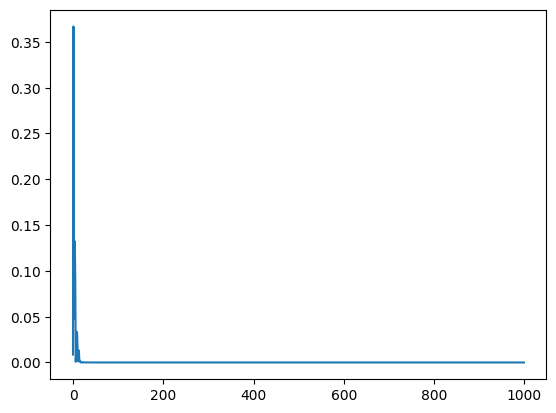

In [122]:
xs = [x for x in range(len(losses))]

# plt.plot(xs, losses)
plt.plot(xs, losses)
plt.show()
plt.close()

In [124]:
item_num = 0
print(model(molecules_dataset[item_num]).item())
print(molecules_dataset[item_num].y.item())

0.14233839511871338
0.14233839511871338
